In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
our_color_palette = {"WT": "#F2C14E", # yellow
                     "W": "#F2C14E", # yellow
                     "IP": "#79ADDC", # blue
                     "I": "#79ADDC", # blue
                     "KO": "#B279A7", # purple
                     "K": "#B279A7", # purple
                    } 
treatments_list = ["W", "I", "K"]
passages_list = ["p1", "p2", "p3", "p5", "p10"]
replicates_list = ['a', 'b', 'c']

In [3]:
df = pd.read_csv("../../resources/additional_data/titers.formated.csv")

# log-transform titer values to "normalize" data distribution 
df["log_titer"] = np.log(df['titer'])
df['rep'] = df['genotype'] + df['replicate']

df.head(5)

,virus,passage,genotype,replicate,titer,log_titer,rep
0,crpv,1,WT,a,3.160000e+08,19.571253,WTa
1,crpv,2,WT,a,4.640000e+09,22.257980,WTa
2,crpv,3,WT,a,4.640000e+09,22.257980,WTa
3,crpv,4,WT,a,3.160000e+09,21.873838,WTa
4,crpv,5,WT,a,4.640000e+09,22.257980,WTa


In [4]:
df.columns

Index(['virus ', 'passage', 'genotype', 'replicate', 'titer', 'log_titer',
       'rep'],
      dtype='object')

In [5]:
p1_wt = df[(df['passage']==1) 
   & (df['virus ']=="crpv") 
   & (df['genotype'].isin(["WT"]))]['titer'].mean()

In [6]:
p1_ip = df[(df['passage']==1) 
   & (df['virus ']=="crpv") 
   & (df['genotype'].isin(["IP"]))]['titer'].mean()

In [7]:
p1_wt/p1_ip

61.10979929161747

In [8]:
p2_wt = df[(df['passage']==1) 
   & (df['virus ']=="crpv") 
   & (df['genotype'].isin(["KO"]))]['titer'].mean()

p2_ip = df[(df['passage']==1) 
   & (df['virus ']=="crpv") 
   & (df['genotype'].isin(["IP"]))]['titer'].mean()

p2_wt/p2_ip

70.83825265643448

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_7390/3372928635.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1271: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data
/Users/lf

<AxesSubplot: xlabel='passage', ylabel='titer'>

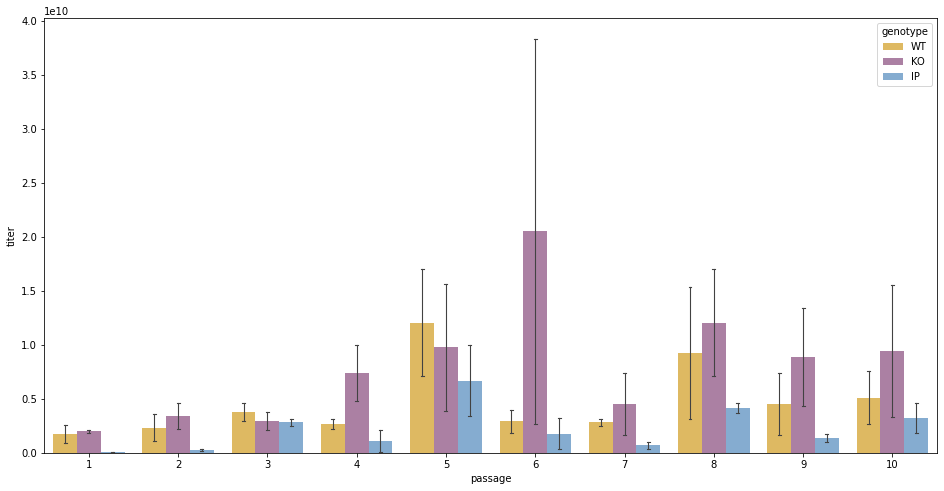

In [9]:
fig, ax = plt.subplots(1,1,  sharey=True, figsize=(16,8))

sns.barplot(
    data=df[df['virus ']=='crpv'], 
    hue='genotype', 
    x='passage', 
    palette=our_color_palette,
    y='titer',
    errwidth=1.1, 
    errorbar="se",
    dodge=0.2,
    capsize=0.1
)

In [10]:
df_crpv = df[df['virus ']=='crpv']
df_dcv = df[df['virus ']=='dcv']

In [11]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError("dlopen(/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): symbol not found in flat namespace '_R_BaseEnv'")
Trying to import in ABI mode.


## crpv

In [12]:
%%R -i df_crpv 

library(nlme)

df_crpv$rep <- as.factor(df_crpv$rep)
df_crpv$genotype <- factor(df_crpv$genotype)

# Relevel the genotype factor with W as reference
df_crpv$genotype <- relevel(df_crpv$genotype, ref = "WT")


df_crpv$passage_factor <- as.factor(df_crpv$passage)
df_crpv$passage_num <- as.numeric(as.character(df_crpv$passage))

In [13]:
### check autocorrelation


	Durbin-Watson test

data:  residuals_mod ~ 1
DW = 1.6898, p-value = 0.06883
alternative hypothesis: true autocorrelation is greater than 0



Lade nötiges Paket: zoo

Attache Paket: ‘zoo’

Die folgenden Objekte sind maskiert von ‘package:base’:

    as.Date, as.Date.numeric

Zusätzlich: Warnmeldungen:
1: Paket ‘lmtest’ wurde unter R Version 4.1.2 erstellt 
2: Paket ‘zoo’ wurde unter R Version 4.1.2 erstellt 


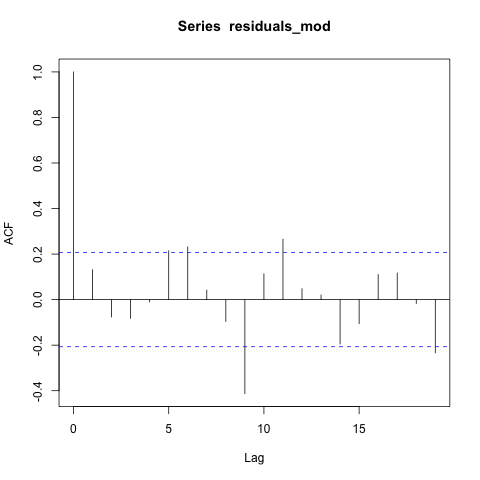

In [14]:
%%R

library(nlme)
library(lmtest)

df_crpv <- df_crpv[order(df_crpv$passage), ]

# Example fitting linear mixed-effects model for your design
mod <- lme(log_titer ~ genotype * passage, 
           random = ~1 | rep, 
           data = df_crpv)

# Extract residuals
residuals_mod <- residuals(mod)

# Plot ACF of residuals
acf(residuals_mod)

# Durbin-Watson test on model
dwtest(residuals_mod ~ 1)

In [15]:
### The ACF plot shows that most autocorrelations at different lags are within the confidence bounds 
### (the blue dashed lines), with only a few minor spikes, indicating that most residuals do not exhibit 
### significant autocorrelation.

### There is no strong statistical evidence of autocorrelation in the residuals at the 0.05 significance 
### level, so autocorrelation is not a major concern for this model.

In [ ]:
### model with autocorrelation 

In [18]:
%%R

mod <- lme(log_titer ~ genotype * passage, 
           random = ~1 | rep, 
           correlation = corAR1(form = ~ 1 | rep),
           data = df_crpv)

In [19]:
%%R
library(emmeans)

emm <- emmeans(mod, pairwise ~ genotype | passage)

sig_contrasts <- summary(emm$contrasts)
sig_filtered <- sig_contrasts[sig_contrasts$p.value < 0.05, ]

if (nrow(sig_filtered) > 0) {
  print(sig_filtered)
} else {
  message("No significant contrasts found with p-value < 0.05.")
}



 contrast passage estimate   SE df t.ratio p.value
 WT - IP      5.5     1.44 0.22  6   6.545  0.0015
 IP - KO      5.5    -1.88 0.22  6  -8.523  0.0004

Degrees-of-freedom method: containment 
P value adjustment: tukey method for comparing a family of 3 estimates 


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'


Converting missing values (`NA`) into regular values currently not
  possible for variables of class `NULL`.


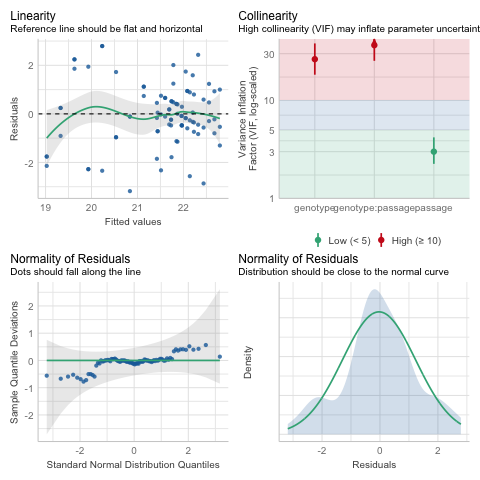

In [20]:
%%R 
library(performance)
check_model(mod)

In [ ]:
### back to without autocorrelation

In [16]:
%%R 
# use mixed ANOVA
# within-subject factor: passage
# indepentent between factor: genotype 
# dependent variable: dcv titers

library(afex)

o1 <- aov_ez("rep", 
             "titer", 
             df_crpv, 
             transformation = "log",
             between = "genotype", 
            within ="passage")
o1


Anova Table (Type 3 tests)

Response: log.titer
            Effect     df  MSE         F  ges p.value
1         genotype   2, 6 0.47 65.39 *** .403   <.001
2          passage  9, 54 1.62  3.86 *** .384   <.001
3 genotype:passage 18, 54 1.62      0.98 .240    .495
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


Lade nötiges Paket: lme4
Lade nötiges Paket: Matrix

Attache Paket: ‘lme4’

Das folgende Objekt ist maskiert ‘package:nlme’:

    lmList

************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- Get and set global package options with: afex_options()
- Set sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attache Paket: ‘afex’

Das folgende Objekt ist maskiert ‘package:lme4’:

    lmer

Contrasts set to contr.sum for the following variables: genotype


In [83]:
%%R 

library(performance) # for assumption checks
check_homogeneity(o1)

OK: There is not clear evidence for different variances across groups (Levene's Test, p = 0.195).


In [84]:
%%R 

library(performance) # for assumption checks
check_sphericity(o1)

OK: Data seems to be spherical (p > .999).


R callback write-console: Zusätzlich:   
R callback write-console: Warnmeldung:
  
R callback write-console: In min(x) :  
R callback write-console:  kein nicht-fehlendes Argument für min; gebe Inf zurück
  


Zusätzlich: Warnmeldung:
In summary.Anova.mlm(object$Anova, multivariate = FALSE) :
  Singular error SSP matrix:
non-sphericity test and corrections not available


Data was changed during ANOVA calculation. Thus, residuals cannot be added to original data.
residuals(..., append = TRUE) will return data and residuals.
Data was changed during ANOVA calculation. Thus, fitted values cannot be added to original data.
fitted(..., append = TRUE) will return data and fitted values.
Data was changed during ANOVA calculation. Thus, residuals cannot be added to original data.
residuals(..., append = TRUE) will return data and residuals.
Data was changed during ANOVA calculation. Thus, fitted values cannot be added to original data.
fitted(..., append = TRUE) will return data and fitted values.
Data was changed during ANOVA calculation. Thus, residuals cannot be added to original data.
residuals(..., append = TRUE) will return data and residuals.
Failed to compute posterior predictive checks with `re_formula=NULL`.
  Trying again with `re_formula=NA` now.


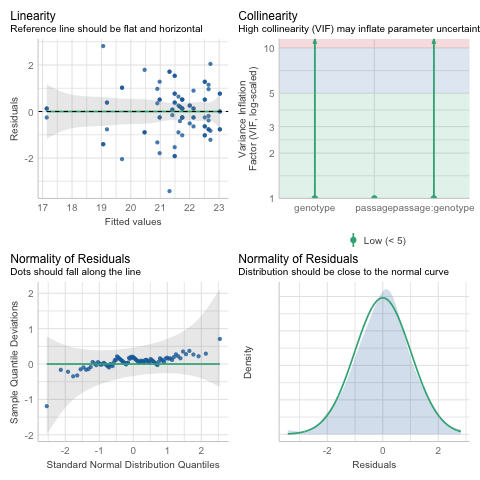

In [85]:
%%R
library(performance) # for assumption checks
check_model(o1)

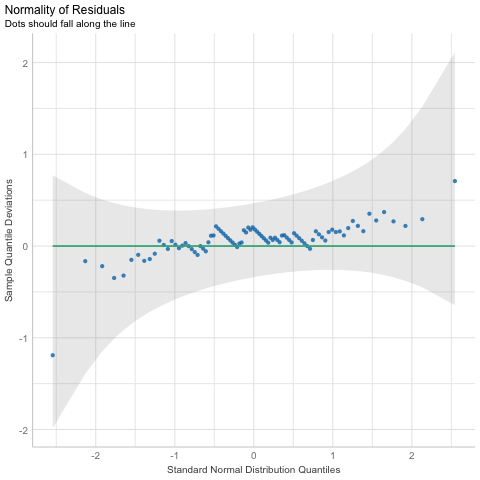

In [86]:
%%R 

library(performance) # for assumption checks

is_norm <- check_normality(o1)

#plot(is_norm)

plot(is_norm, type = "qq", detrend = TRUE)

In [87]:
%%R

library(emmeans)
library(ggplot2)
library(dplyr)
library(ggpubr)

# Example color palette
our_color_palette <- c("WT" = "#F2C14E",  # yellow
                       "IP" = "#79ADDC",  # blue
                       "KO" = "#B279A7")  # purple


# Pairwise comparisons of genotype at each passage level
emm_pw <- emmeans(o1, pairwise ~ genotype | passage, adjust = "bonferroni")
emm_summary <- as.data.frame(summary(emm_pw$emmeans))

# Extract the p-value results from the pairwise comparisons
p_value_results <- as.data.frame(summary(pairs(emm_pw, by = "passage")))

# Add significance levels and filter for significant differences
sig_results <- p_value_results %>%
  mutate(sig.level = case_when(
    p.value <= 0.001 ~ "***",
    p.value <= 0.01 ~ "**",
    p.value <= 0.05 ~ "*",
    TRUE ~ "ns"
  )) %>%
  filter(sig.level != "ns")

# Extract genotype information to sig_results
sig_results <- sig_results %>%
  mutate(genotype1 = gsub(" - .*", "", contrast),
         genotype2 = gsub(".* - ", "", contrast))

# Ensure passage is a factor with consistent levels
emm_summary$genotype <- factor(emm_summary$genotype, levels = levels(emm_summary$genotype))

# Get unique passages
unique_passages <- unique(emm_summary$passage)

# Calculate y positions for the brackets
y_start <- max(emm_summary$upper.CL) + 1
y_increment <- 1.5
sig_results <- sig_results %>%
  group_by(passage) %>%
  mutate(y.position = y_start + y_increment * row_number())


Zusätzlich: Warnmeldung:
Paket ‘ggpubr’ wurde unter R Version 4.1.2 erstellt 


In [89]:
%%R

sig_results

# A tibble: 2 × 11
# Groups:   passage [1]
  contrast passage estimate    SE    df t.ratio  p.value sig.level genotype1
  <fct>    <fct>      <dbl> <dbl> <dbl>   <dbl>    <dbl> <chr>     <chr>    
1 WT - IP  X1          3.76 0.575     6    6.54 0.00149  **        WT       
2 IP - KO  X1         -4.27 0.575     6   -7.43 0.000749 ***       IP       
# ℹ 2 more variables: genotype2 <chr>, y.position <dbl>
